In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import re

In [2]:
def create_graph(edges):
    # Create an undirected graph
    graph = nx.Graph()            
        
    # Add edges to the graph
    # You can customize this part based on your specific graph or load it from external data
    graph.add_edges_from(edges)

    return graph

def create_neg_graph(g):
    # Create an undirected graph
    graph = nx.Graph()  
    
    
    edges = []
    
    for node in g:
        for nei, sign in g[node]:
            if sign != 1:
                edge = (node, nei)
                edges.append(edge)
        
    # Add edges to the graph
    # You can customize this part based on your specific graph or load it from external data
    graph.add_edges_from(edges)

    return graph

def preparing_edges_to_visualize(file_path):
    edges = []
    with open(file_path, "r") as file:
        for line in file:
            #u, v, sign = map(int, line.strip().split("\t"))
            u, v, sign = map(int, re.split(r'\t|\s+', line.strip()))
            edges.append((u, v, {'sign': sign}))
    return edges


def calculate_delta(graph, upper_bounds):
    delta_values = {}
    # Calculate delta for each vertex
    for node in graph.nodes():
        degree = graph.degree(node)
        upper_bound = upper_bounds[node]
        delta = degree - upper_bound
        delta_values[node] = delta

    return delta_values

def create_bipartite_graph(node, delta, degree, combined_bipartite_edges, graph_dict):

    bipartite_graph = nx.Graph()

    # Add nodes to the first class
    # range starts from node value to node+delta value
    
    delta_node_names = []
    
    
    for i in range(0, delta):
        if i != 0:
            delta_node_name = str(node) + "." + str(i)
            delta_node_names.append(delta_node_name)
        else:
            delta_node_names.append(node)
    
    bipartite_graph.add_nodes_from(delta_node_names, bipartite=0)


    # Add nodes to the second class
    bipartite_graph.add_nodes_from(graph_dict[str(node)], bipartite=1)

    # Add edges between nodes of opposite classes
    bipartite_graph.add_edges_from([(delta_node, degree_node) for delta_node in delta_node_names for degree_node in graph_dict[str(node)]])
    
    #getting edges from eact subgraphs
    for primary_edge, secondary_edge in bipartite_graph.edges():
        edge = (primary_edge, (str(node) +","+ str(secondary_edge)))
            
        #appending edges
        combined_bipartite_edges.append(edge)
        
    return (bipartite_graph, node)


def display_all_bipartite_graphs(bipartite_graphs, n):
    
    plt.figure(figsize=(12, 8))
    
    for i, (bipartite_graph, node) in enumerate(bipartite_graphs):
        plt.subplot(int(len(n)/2), 3, i + 1)
        pos = nx.spring_layout(bipartite_graph)
        nx.draw(bipartite_graph, pos, with_labels=True, font_weight='bold', node_color=['skyblue' if bipartite == 0 else 'lightcoral' for bipartite in nx.get_node_attributes(bipartite_graph, 'bipartite').values()], node_size=500, edgecolors='black', linewidths=1.0)
        plt.title(f"Bipartite Graph for Node {node}")

    plt.tight_layout()
    plt.show()

In [3]:
def read_signed_graph_from_file(file_path):
    graph = {}
    
    unsigned_graph = []
    
    with open(file_path, 'r') as file:
        for line in file:
            source, target, weight = map(int, line.strip().split())
            unsigned_graph.append((source, target, {"sign": weight}))
            
            if source not in graph:
                graph[source] = []
            if target not in graph:
                graph[target] = []
            graph[source].append((target, weight))
            graph[target].append((source, weight))
    return graph, unsigned_graph

def finding_positive_and_negative_neighbours(g):
    
    all_pos_connections = {}
    all_neg_connections = {}
    
    for node in g:
        pos_nei = []
        neg_nei = []
        
        for nei, sign in g[node]:
            if sign == 1:
                pos_nei.append(nei)
            elif sign == -1:
                neg_nei.append(nei)
            
        all_pos_connections[node] = {"neighbour": pos_nei}
        all_neg_connections[node] = {"neighbour": neg_nei}
        
        
        all_pos_connections[node]['total_count'] = len(pos_nei)
        all_neg_connections[node]['total_count'] = len(neg_nei)
        
        
        all_pos_connections[node]['inside_d_count'] = 0
        all_neg_connections[node]['inside_d_count'] = 0
        
        all_pos_connections[node]['inside_d_neighbour'] = []
        all_neg_connections[node]['inside_d_neighbour'] = []
    
#     for node in g:
#         all_pos_connections[node]['total_count'] = len(all_pos_connections[node]['neighbour'])
#         all_pos_connections[node]['inside_d_count'] = 0
        
#         all_neg_connections[node]['total_count'] = len(all_neg_connections[node]['neighbour'])
#         all_neg_connections[node]['inside_d_count'] = 0
    
    
    return all_pos_connections, all_neg_connections
            
    
def pos_neg_inside_d_or_not(d, all_positive, all_negative):
    
    all_pos = all_positive
    all_neg = all_negative
    
    b = []
    
    for node in d:
        to_check = [elem for elem in d if elem != node]
        
        for checking_value in to_check:
            if checking_value in all_pos[node]['neighbour']:
                all_pos[node]['total_count'] -= 1
                all_pos[node]['inside_d_count'] += 1
                
                all_pos[node]['neighbour'].remove(checking_value)
                all_pos[node]['inside_d_neighbour'].append(checking_value) 
                
                
            elif checking_value in all_neg[node]['neighbour']:
                all_neg[node]['total_count'] -= 1
                all_neg[node]['inside_d_count'] += 1
                
                all_neg[node]['neighbour'].remove(checking_value)
                all_neg[node]['inside_d_neighbour'].append(checking_value)
            
        node_max_neg_count = max(all_neg[node]['total_count'], all_neg[node]['inside_d_count'])
        
        if (all_pos[node]['inside_d_count'] + 1) < node_max_neg_count:
            b.append(node)
    
    return b, all_pos, all_neg


def check_upper_bound(graph, b, all_pos, all_neg):
    upper_bound = {}
    
    for node in graph:
        if node not in b:
            upper_bound[node] = 0
        else:
            b1 = all_neg[node]['total_count'] - all_pos[node]['inside_d_count'] - 1
            
            b2 = math.ceil((all_neg[node]['inside_d_count'] - all_pos[node]['inside_d_count'] - 1) / 2)
            
            upper_bound[node] = max(b1, b2)
            
    return upper_bound

def find_max_edge(matching):
    edges = []
    for node, nei in matching:  
        vertex1 = str(node).split(',')
        vertex2 = str(nei).split(',')[::-1]
        
        if len(vertex1) == len(vertex2):
            if vertex1[0] == vertex2[0] and vertex1[1] == vertex2[1]:
                if int(vertex1[0]) < int(vertex1[1]):
                    edges.append(( int(vertex1[0]), int(vertex1[1])))
                else:
                    edges.append(( int(vertex1[1]), int(vertex1[0])))
                    
    return list(set(edges))
    
    
def finding_bipratie_graph_connecting_edges(combined_bipartite_edges):
    connecting = []
    rev_nodes = []

    # Iterate through the list to build mappings
    for node1, node2 in combined_bipartite_edges: 
        
        rev_node = (str(node2)[::-1])
        edge_set = (node2, rev_node)
        if rev_node not in rev_nodes:
            if edge_set not in connecting:
                connecting.append((node2, rev_node))
                rev_nodes.append(rev_node)
                rev_nodes.append(node2)
                
    return connecting
    
    

Graph with Upper Degree Constraints:
[(1, {'upper_bound': 2}), (3, {'upper_bound': 0}), (7, {'upper_bound': 0}), (6, {'upper_bound': 0}), (5, {'upper_bound': 0}), (4, {'upper_bound': 0}), (2, {'upper_bound': 0})]

Delta Values:
{1: 3, 3: 3, 7: 3, 6: 2, 5: 3, 4: 3, 2: 1}


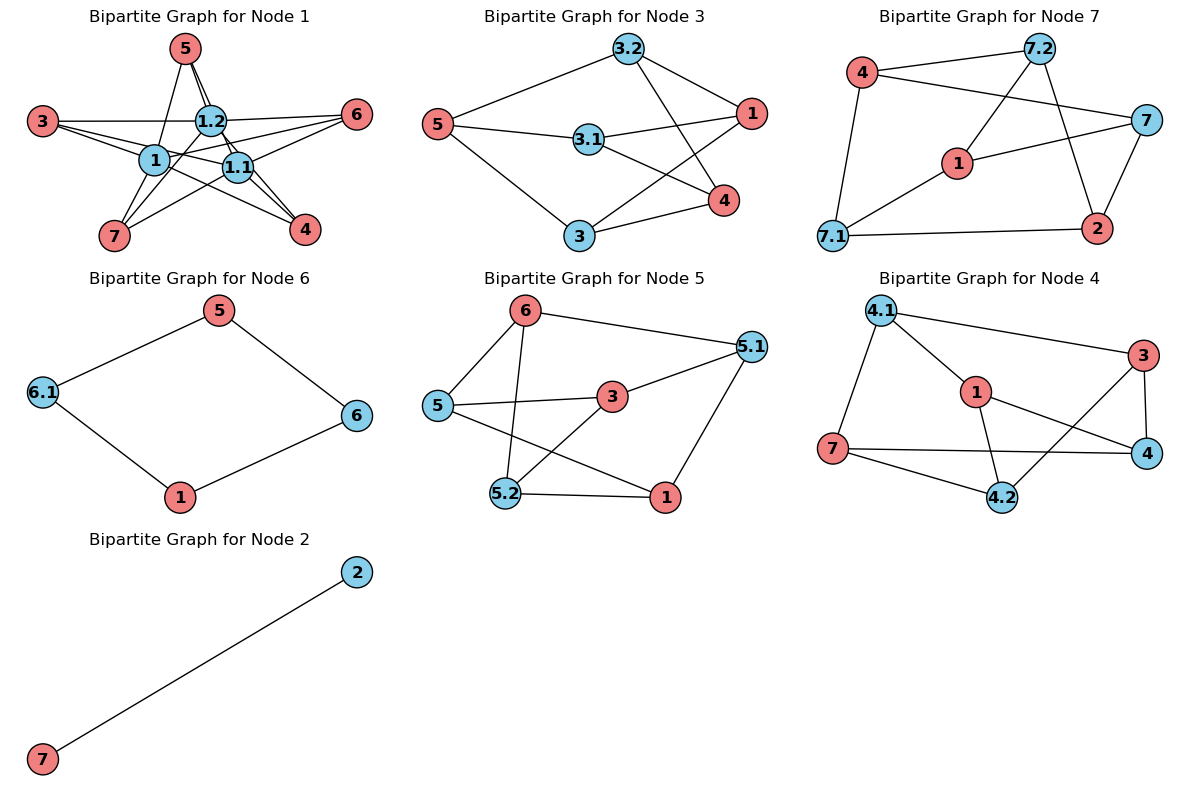

Matching: {('5.2', '5,1'), ('2,7', 2), ('5,6', 5), ('4.2', '4,1'), ('7.2', '7,1'), ('6.1', '6,1'), ('7.1', '7,2'), ('4.1', '4,3'), ('5.1', '5,3'), ('6,5', 6), ('7,4', 7), ('1.2', '1,3'), ('4,7', 4), ('3.2', '3,1'), ('3.1', '3,4'), ('1.1', '1,4'), ('3,5', 3), ('1,7', 1)}


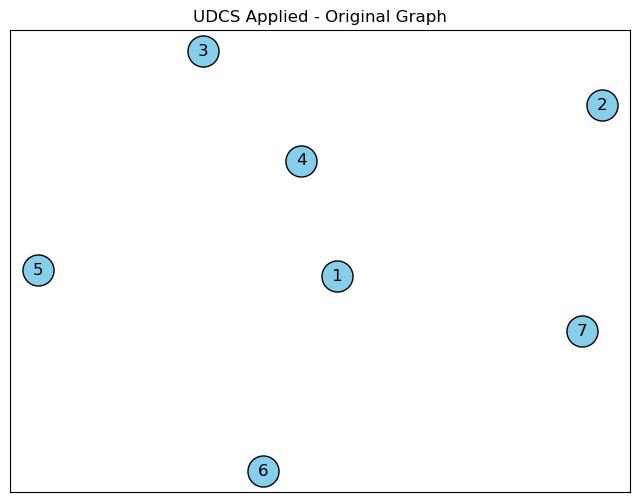

In [46]:
# Create the graph
file_path = r"/Users/mac/Desktop/Desktop/RCS_Signed_Graph/Meeting_4/graph_test_files/test4.txt"

# here graph means signed graph edge set. original_graph means same unsigned graph edge set.
graph, original_graph  = read_signed_graph_from_file(file_path) 

# getting the vertex which has to be check for UDCS from user
d = [1,2,3]
k = 2

# Find positive and negative edges and store the counts of degrees. 
all_positive, all_negative = finding_positive_and_negative_neighbours(graph)

# Find the B vertex get by checking conditions
b, all_positive_after_check, all_negative_after_check = pos_neg_inside_d_or_not(d, all_positive, all_negative)


my_graph = create_graph(original_graph)

my_neg_graph = create_neg_graph(graph)

# Check the upper boundary for each node and set the values Accordingly based on condition b1 and b2
upper_bounds_dict = check_upper_bound(my_graph, b, all_positive_after_check, all_negative_after_check)



# Making dictionary for other purpose
graph_dict = {}

for edge in original_graph:
    if edge[2]['sign'] != 1:
        graph_dict.setdefault(str(edge[0]), []).append(edge[1])
        graph_dict.setdefault(str(edge[1]), []).append(edge[0])

# Convert values to sets to remove duplicate neighbors
graph_dict = {key: list(set(value)) for key, value in graph_dict.items()}


# Set upper bounds as node attributes
nx.set_node_attributes(my_neg_graph, upper_bounds_dict, 'upper_bound')

# Print the graph with upper degree constraints
print("Graph with Upper Degree Constraints:")
print(my_neg_graph.nodes(data=True))

# Calculate delta values for each vertex
delta_values_dict = calculate_delta(my_neg_graph, upper_bounds_dict)

# Print the delta values for each vertex
print("\nDelta Values:")
print(delta_values_dict)

# list to combine edges from original and sub graphs
combined_bipartite_graph = []

# Create bipartite graphs for each vertex
bipartite_graphs = [create_bipartite_graph(node, 
                                           delta_values_dict[node], 
                                           my_neg_graph.degree(node), 
                                           combined_bipartite_graph,
                                           graph_dict) for node in my_neg_graph.nodes()]

# Display individual bipartite graphs
display_all_bipartite_graphs(bipartite_graphs,  my_graph.nodes())


# Create a dictionary to store same edge connections (eg, [(31, 13), (21, 12)])
connecting_bipartite_edges = finding_bipratie_graph_connecting_edges(combined_bipartite_graph)
# print(connecting_bipartite_edges)

# combining bipartite graphs and connecting_bipartite_egdes 
for edges in connecting_bipartite_edges:
    combined_bipartite_graph.append(edges)


# Display the graph with connected bipartite subgraphs
com_graph = create_graph(combined_bipartite_graph)

pos_combined = nx.spring_layout(com_graph)


# renamed_graph = nx.relabel_nodes(com_graph, renaming_label)
# pos_combined = nx.spring_layout(renamed_graph)

# org_graph = nx.spring_layout(my_graph)

sub_graph_edges = []
delta_list = []

# for edge in renamed_graph.edges():
for edge in com_graph.edges():
    if edge not in my_graph.edges():
        sub_graph_edges.append(edge)
    
for node in com_graph.nodes():
    if isinstance(node, str):
        delta_list.append(node)

        
# Example usage:
matching = nx.algorithms.matching.max_weight_matching(com_graph, maxcardinality=False)
print("Matching:", matching)
udcs_matching_edges = find_max_edge(matching)

# print(com_graph.edges())
# print(upper_bounds_dict)


edges = preparing_edges_to_visualize(file_path)

# Create a signed graph
signed_graph = nx.Graph()
signed_graph.add_edges_from(edges)

pos = nx.spring_layout(signed_graph)
positive_edges = [(u, v) for u, v, data in signed_graph.edges(data=True) if data['sign'] == 1]
negative_edges = [(u, v) for u, v, data in signed_graph.edges(data=True) if data['sign'] == -1]

plt.figure(figsize=(8,6))

nx.draw_networkx_nodes(signed_graph, pos, node_color="skyblue", node_size=500, edgecolors='black', linewidths=1.0)
# nx.draw_networkx_edges(signed_graph, pos, edgelist=positive_edges, edge_color='green')
# nx.draw_networkx_edges(signed_graph, pos, edgelist=negative_edges, edge_color='red')
nx.draw_networkx_edges(signed_graph, pos, edgelist=udcs_matching_edges, edge_color='blue', width=3.0)
nx.draw_networkx_labels(signed_graph, pos, font_size=12, font_color='black')

plt.title("UDCS Applied - Original Graph")

# Create subplots
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Plot data in the first subplot (axes[0])
# nx.draw_networkx_nodes(com_graph, pos_combined, node_size=1000, node_color= 'lightcoral', edgecolors='black', linewidths=1.0, ax = axes[0])
# nx.draw_networkx_nodes(com_graph, pos_combined, nodelist = my_graph.nodes(),  node_color="skyblue", node_size=1000, edgecolors='black', linewidths=1.0, ax = axes[0])
# nx.draw_networkx_nodes(com_graph, pos_combined, nodelist = delta_list,  node_color="skyblue", node_size=1000, edgecolors='black', linewidths=1.0, ax = axes[0])
# nx.draw_networkx_edges(com_graph, pos_combined, edgelist=sub_graph_edges, edge_color='black', ax = axes[0])
# nx.draw_networkx_labels(com_graph, pos_combined, font_size=12, font_color='black', ax = axes[0])
# nx.draw(com_graph, pos_combined, with_labels=True, node_color='skyblue', node_size=1500, font_size=12, font_weight='bold')
# plt.show()
# axes[0].set_title('Combined Bipartited graphs')
# axes[0].legend()

# Plot data in the second subplot (axes[1])
# nx.draw_networkx_nodes(my_graph, org_graph,  node_color="skyblue", node_size=500, edgecolors='black', linewidths=1.0, ax = axes[1])
# nx.draw_networkx_edges(my_graph, org_graph, edge_color='black', ax = axes[1])
# nx.draw_networkx_labels(my_graph, org_graph, font_size=12, font_color='black', ax = axes[1])
# axes[1].set_title('Original graphs')
# axes[1].legend()

# plt.tight_layout()

plt.show()




### Namings
# Delta node represented as "." (eg: "1.2", "1.3", "1.4")
# bipartited-degree-nodes represented as "," (eg: "1,2" "1,3" "1,4")

# in bipartited graph we connect delta node with degree node
# for combining bipartited graph with other bipartited graph we connect degree node 
# with degree node (eg: "3,1" connect with "1,3")

## Reduction

In [47]:
def form_s(neg_neighbors_in_d, neg_neighbors_out_d, z, node):
    
    nei_in_d = []
    nei_out_d = []
    
    s = []
    
    for nei in neg_neighbors_in_d:
        nei_in_d.append((node, nei))
        
        
    for nei in neg_neighbors_out_d:
        nei_out_d.append((node, nei))
        
    
    for values in nei_in_d:
        s.append(values)
    
    for idx, values in enumerate(nei_out_d):
        if idx < z:
            s.append(nei_out_d[idx])
     
    return s,nei_in_d,nei_out_d
    

def check_reduction(all_pos, all_neg, node):
    
         # neg_outside_d - pos_inside_d - neg_inside_d - 1
    z =  all_neg[node]['total_count'] - all_pos[node]['inside_d_count'] - all_neg[node]['inside_d_count'] - 1
        
    if z >= 0:
        s,nei_in_d,nei_out_d = form_s(all_negative_after_check[node]['inside_d_neighbour'], 
                    all_negative_after_check[node]['neighbour'],
                    z, node )
        
    return s,nei_in_d,nei_out_d
        



In [48]:
deg_in_udcs_matching_edges = {}

for node in b:
    deg_in_udcs_matching_edges[node] = 0
    
    for edge in udcs_matching_edges:
        for vertex1, vertex2 in edge:
            if node == vertex1 or node == vertex2:
                deg_in_udcs_matching_edges[node] += 1
    
            
temp_udcs_matching_edges = udcs_matching_edges.copy()

# for edge in b:
for node in b:

    if deg_in_udcs_matching_edges[node] < upper_bounds_dict[node]:
        s, nei_in_d, nei_out_d = check_reduction(all_positive_after_check, all_negative_after_check, node)
            
        inequality_count = upper_bounds_dict[node] - deg_in_udcs_matching_edges[node]
            
        ## prioritizing edges to flip inside d. 
        idx = 0
        while inequality_count > 0:
            if idx > len(s) - 1:
                break
                    
            if s[idx] not in udcs_matching_edges:
                if s[idx] in nei_in_d:
                    udcs_matching_edges.append(s[idx])
                    inequality_count -= 1 
            idx += 1
                
        ## edges to flip 
        idx = 0 
        while inequality_count > 0:
            if idx > len(s) - 1:
                break
            if s[idx] not in udcs_matching_edges:
                udcs_matching_edges.append(s[idx])
                inequality_count -= 1
            idx += 1
         
        

In [49]:
print(udcs_matching_edges)

[(1, 3), (1, 7)]


In [50]:
if len(udcs_matching_edges) <= k:
    print("Building defensive alliance by flipping atmost K edges is possible")
else:
    print("Building defensive alliance by flipping atmost K edges is not possible")

Building defensive alliance by flipping atmost K edges is possible


In [51]:

for node, nei, sign in original_graph:
    print(node, nei, sign)
    
    edge = (node, nei)
    
    if edge in udcs_matching_edges:
        sign['sign'] = 1
        
print(original_graph)

1 2 {'sign': 1}
1 3 {'sign': -1}
1 7 {'sign': -1}
1 6 {'sign': -1}
1 5 {'sign': -1}
1 4 {'sign': -1}
2 7 {'sign': -1}
2 3 {'sign': 1}
3 4 {'sign': -1}
3 5 {'sign': -1}
4 5 {'sign': 1}
5 6 {'sign': -1}
6 7 {'sign': 1}
4 7 {'sign': -1}
[(1, 2, {'sign': 1}), (1, 3, {'sign': 1}), (1, 7, {'sign': 1}), (1, 6, {'sign': -1}), (1, 5, {'sign': -1}), (1, 4, {'sign': -1}), (2, 7, {'sign': -1}), (2, 3, {'sign': 1}), (3, 4, {'sign': -1}), (3, 5, {'sign': -1}), (4, 5, {'sign': 1}), (5, 6, {'sign': -1}), (6, 7, {'sign': 1}), (4, 7, {'sign': -1})]
